# Brain Tumor Detection using Efficient Net 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split

#tensor flow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

#tensor flow models densenet, mobilenet, effecient net
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetV2B1
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import DenseNet121


from tqdm import tqdm
import os


from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2024-05-11 02:37:17.907337: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-11 02:37:17.907440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-11 02:37:18.040931: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(84).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(44).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(245).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/6.jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(238).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(196).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(108).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(310).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image (5).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(186).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(29).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(140).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(224).jpg

In [2]:
#initialize variable to store image and label sets
Images = []
Label_tag = []
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
#Pre setting the image size to 150
image_size = 150

In [3]:
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        Images.append(img)
        Label_tag.append(i)
        
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        Images.append(img)
        Label_tag.append(i)
        
Images = np.array(Images)
Label_tag = np.array(Label_tag)

100%|██████████| 74/74 [00:00<00:00, 98.28it/s] 


In [4]:
#printing unique labels present
print( np.unique(Label_tag))

['glioma_tumor' 'meningioma_tumor' 'no_tumor' 'pituitary_tumor']


# Data Visualization

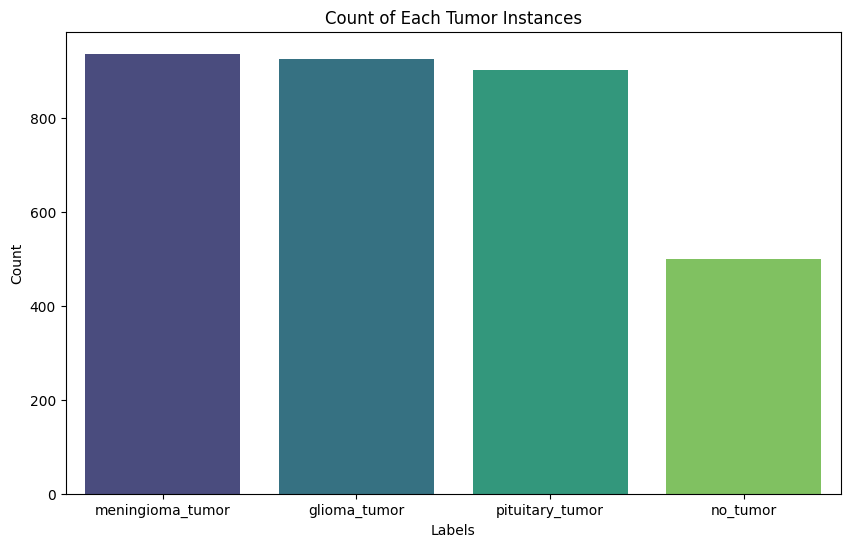

In [5]:
label_counts = pd.Series(Label_tag).value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Count of Each Tumor Instances')


plt.show()

# Plotting example images with their respective tumor types

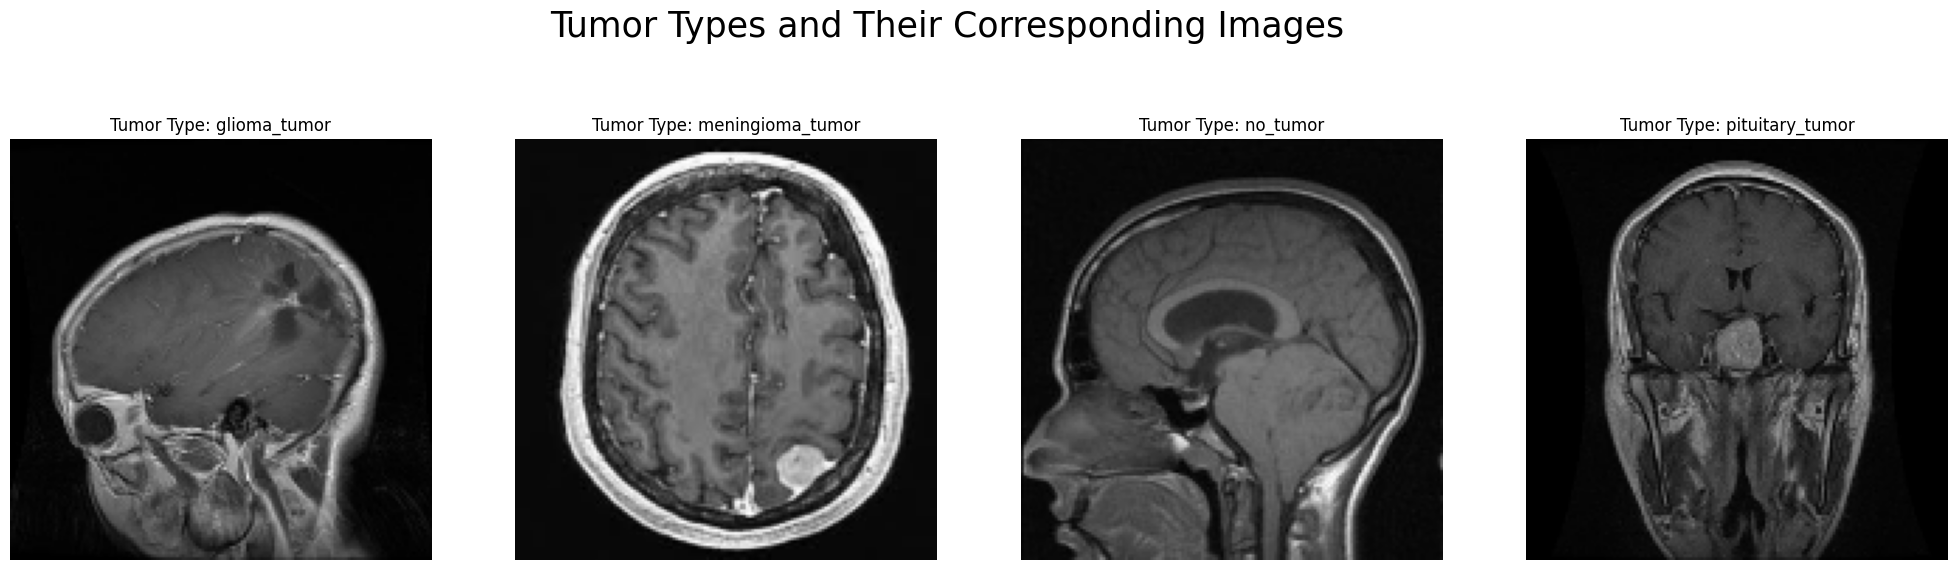

In [6]:
indexes = {label: np.where(Label_tag == label)[0][0] for label in np.unique(Label_tag)}


sample_images = [Images[idx] for idx in indexes.values()]


fig, ax = plt.subplots(1, len(sample_images), figsize=(25, 7))
fig.suptitle('Tumor Types and Their Corresponding Images', fontsize=25)


for i, (label, img) in enumerate(zip(indexes.keys(), sample_images)):
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  
    ax[i].set_title(f"Tumor Type: {label}")
    ax[i].axis('off')  


plt.show()

In [7]:
Images,Label_tag = shuffle(Images,Label_tag, random_state=101)

In [8]:
#Checking Image shape
Images.shape

(3264, 150, 150, 3)

# Data Augmentation

To achieve better accuracy and improve the model's robustness, we use data augmentation.

The techniques we'll employ are:

* Rotation: This rotates the image; we will rotate it by up to 15 degrees in either direction.
* Horizontal Flip: This randomly flips the image horizontally.
* Fill Mode: When the image is transformed, there can be empty spaces. fill_mode='nearest' ensures those spaces are filled with the nearest pixel values to maintain continuity.

In [9]:
data_augmentation = ImageDataGenerator(
    rotation_range=15,  # Rotate images by up to 15 degrees in either direction
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'
)

# Train Test Split

In [10]:
X_train,X_test,y_train,y_test = train_test_split(Images,Label_tag, test_size=0.1,random_state=101)

In [11]:
y_train

array(['glioma_tumor', 'no_tumor', 'no_tumor', ..., 'meningioma_tumor',
       'pituitary_tumor', 'meningioma_tumor'], dtype='<U16')

# One-Hot Encoding

* As the labels are in categorical format, we perform one-hot encoding.
* One-hot encoding is a method used to convert categorical data into a numerical format that can be used by machine learning algorithms.

In [12]:
one_hot_train = []
for i in y_train:
    one_hot_train.append(labels.index(i))
y_train = one_hot_train
y_train = tf.keras.utils.to_categorical(y_train)


one_hot_test = []
for i in y_test:
    one_hot_test.append(labels.index(i))
y_test = one_hot_test
y_test = tf.keras.utils.to_categorical(y_test)

Example of one hot encoded variable 

In [13]:
y_train_tensor = tf.convert_to_tensor(y_train[1500])
print(y_train_tensor.numpy())

[0. 0. 1. 0.]


# Train Validation Split
We are now splitting the training dataset because we require a validation dataset to assess the model's performance.

In [14]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

Now, we'll apply the data augmentation function we created to the training set, while leaving the validation set unchanged.

In [15]:
train_generator = data_augmentation.flow(
    X_train, y_train, batch_size=32
)

val_generator = ImageDataGenerator().flow(
    X_val, y_val, batch_size=32
)

#  The model performs poorly with standard neural networks. To address this, we introduce transfer learning. Transfer learning is a machine learning technique where a pre-trained model, usually trained on a large dataset for a complex task, is repurposed for a different, but related, task.

#  We will use EfficientNetV2B1 as our transfer learning model. It uses weights from ImageNet, and by setting `include_top=False`, we can define our own custom output layer.

In [16]:
EfficientNet = EfficientNetV2B1(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

28456008/28456008 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


For this Model

(GlobalAveragePooling2D)GAP takes the average of all values across a given spatial dimension. In the context of 2D images, this means averaging across all pixels in each feature map. GAP tends to be more robust and stable because it considers the average of all values, making it less sensitive to noise or outliers.
It retains some information about the "general pattern" of each feature map.

We perform dropout so as to keep the model from relying too much on any specific details (which could lead to overfitting), we randomly remove some of that compressed data while training. In this case we set it to 0.5

The final layer, which is a dense (fully connected) layer, has four output units with a softmax activation function. These four output units correspond to the four types of tumors that the machine learning model is designed to predict.

In [17]:
model = EfficientNet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=EfficientNet.input, outputs = model)

In [18]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 150, 150,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 75, 75,    │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 75, 75,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 75, 75,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 75, 75,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 75, 75,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 75, 75,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 75, 75,    │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 75, 75,    │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 75, 75,    │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 75, 75,    │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 75, 75,    │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 38, 38,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 38, 38,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 38, 38,    │          0 │ block2a_expand_b

 Total params: 6,936,248 (26.46 MB)

 Trainable params: 6,865,176 (26.19 MB)

 Non-trainable params: 71,072 (277.62 KB)

In [19]:
#compile the model
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

We apply a few callback functions which will help imporve models performance and accuracy and visulaization.

The TensorBoard callback allows one to visualize various metrics, such as training and validation loss, accuracy, and more, during training.

The ModelCheckpoint callback saves the model's weights to a file during training. Here's a summary of the key parameters:
* monitor: Specifies which metric to track, such as validation accuracy.
* save_best_only: If True, the model is saved only when the monitored metric shows improvement.
* mode: Determines how to evaluate the metric for improvement ("auto", "min", or "max").
* verbose=1: Controls the level of output detail; 1 provides some feedback on the checkpointing process.


The ReduceLROnPlateau callback automatically decreases the learning rate when a specified metric, such as val_accuracy, stops improving. Key parameters include:
* factor: The factor by which the learning rate is reduced, for example, by 0.3 (or 30%).
* patience: The number of epochs with no improvement before reducing the learning rate.
* min_delta: The minimum change in the monitored metric to consider it an improvement.
* mode: Specifies whether improvement is gauged by an increase or decrease in the metric.
* verbose: If set to 1, provides detailed information about learning rate changes.


In [20]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("EfficientNet.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

We now run the model, we set epochs to 12 and batch size to 32

In [21]:
history = model.fit(train_generator,
                    validation_data=val_generator, 
                    epochs =12, 
                    verbose=1, 
                    batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1715395216.449986      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6978 - loss: 0.7738
Epoch 1: val_accuracy improved from -inf to 0.87075, saving model to EfficientNet.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.6989 - loss: 0.7713 - val_accuracy: 0.8707 - val_loss: 0.4414 - learning_rate: 0.0010
Epoch 2/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8835 - loss: 0.3020
Epoch 2: val_accuracy did not improve from 0.87075
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.8836 - loss: 0.3019 - val_accuracy: 0.8503 - val_loss: 0.5604 - learning_rate: 0.0010
Epoch 3/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9101 - loss: 0.2573
Epoch 3: val_accuracy improved from 0.87075 to 0.92177, saving model to EfficientNet.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.9102 - loss: 0.2572 - val_accuracy: 0.9218 - val_loss: 0.2339 - learning_rate: 0.0010
Epoch 4/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9368 - loss: 0.1714
Epoch 4: val_acc

# We now plot the Graphs for training vs validation scores

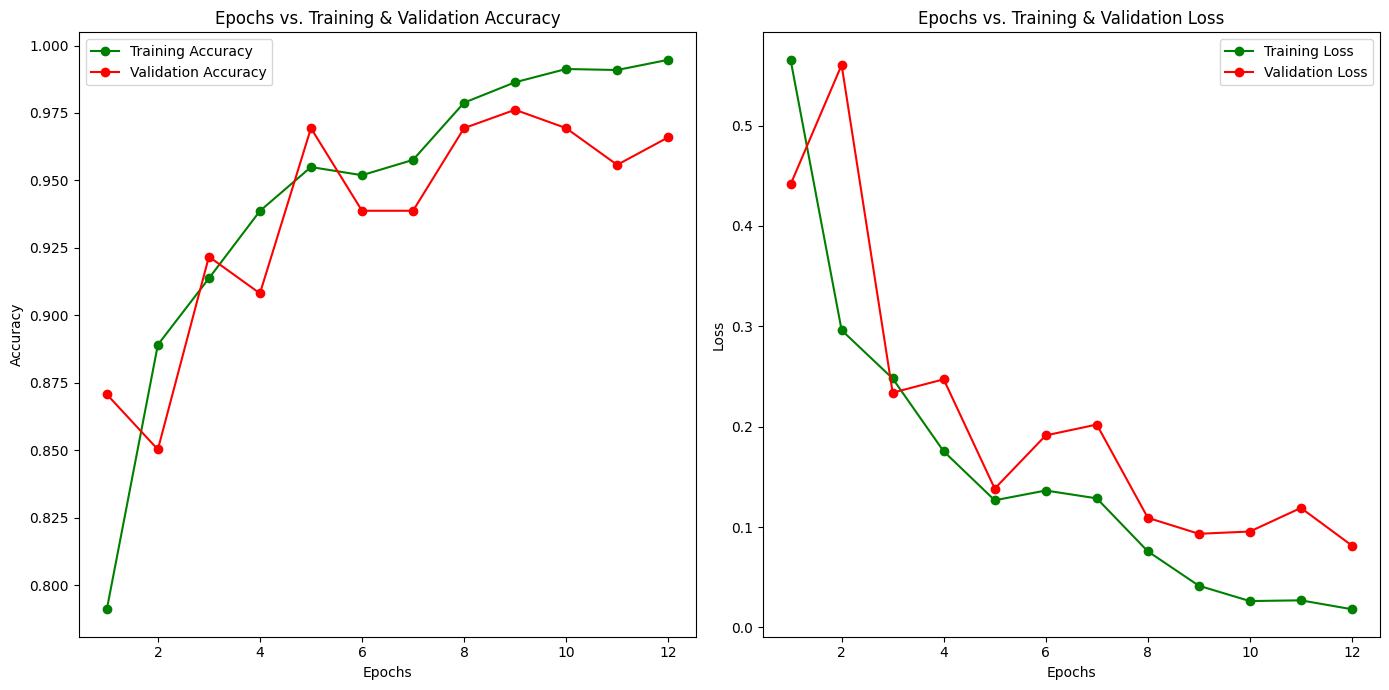

In [22]:
epochs = range(1, len(history.history['accuracy']) + 1)

# Create a subplot with 2 plots: accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Plot training and validation accuracy
ax[0].plot(epochs, history.history['accuracy'], 'o-', color='g', label='Training Accuracy')
ax[0].plot(epochs, history.history['val_accuracy'], 'o-', color='r', label='Validation Accuracy')
ax[0].set_title('Epochs vs. Training & Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot training and validation loss
ax[1].plot(epochs, history.history['loss'], 'o-', color='g', label='Training Loss')
ax[1].plot(epochs, history.history['val_loss'], 'o-', color='r', label='Validation Loss')
ax[1].set_title('Epochs vs. Training & Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()

We Predict the Test Data

In [23]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 915ms/step


In [24]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

The following code is used to print a few images with their actual and predicted label comparisons along with confidence index scores.

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


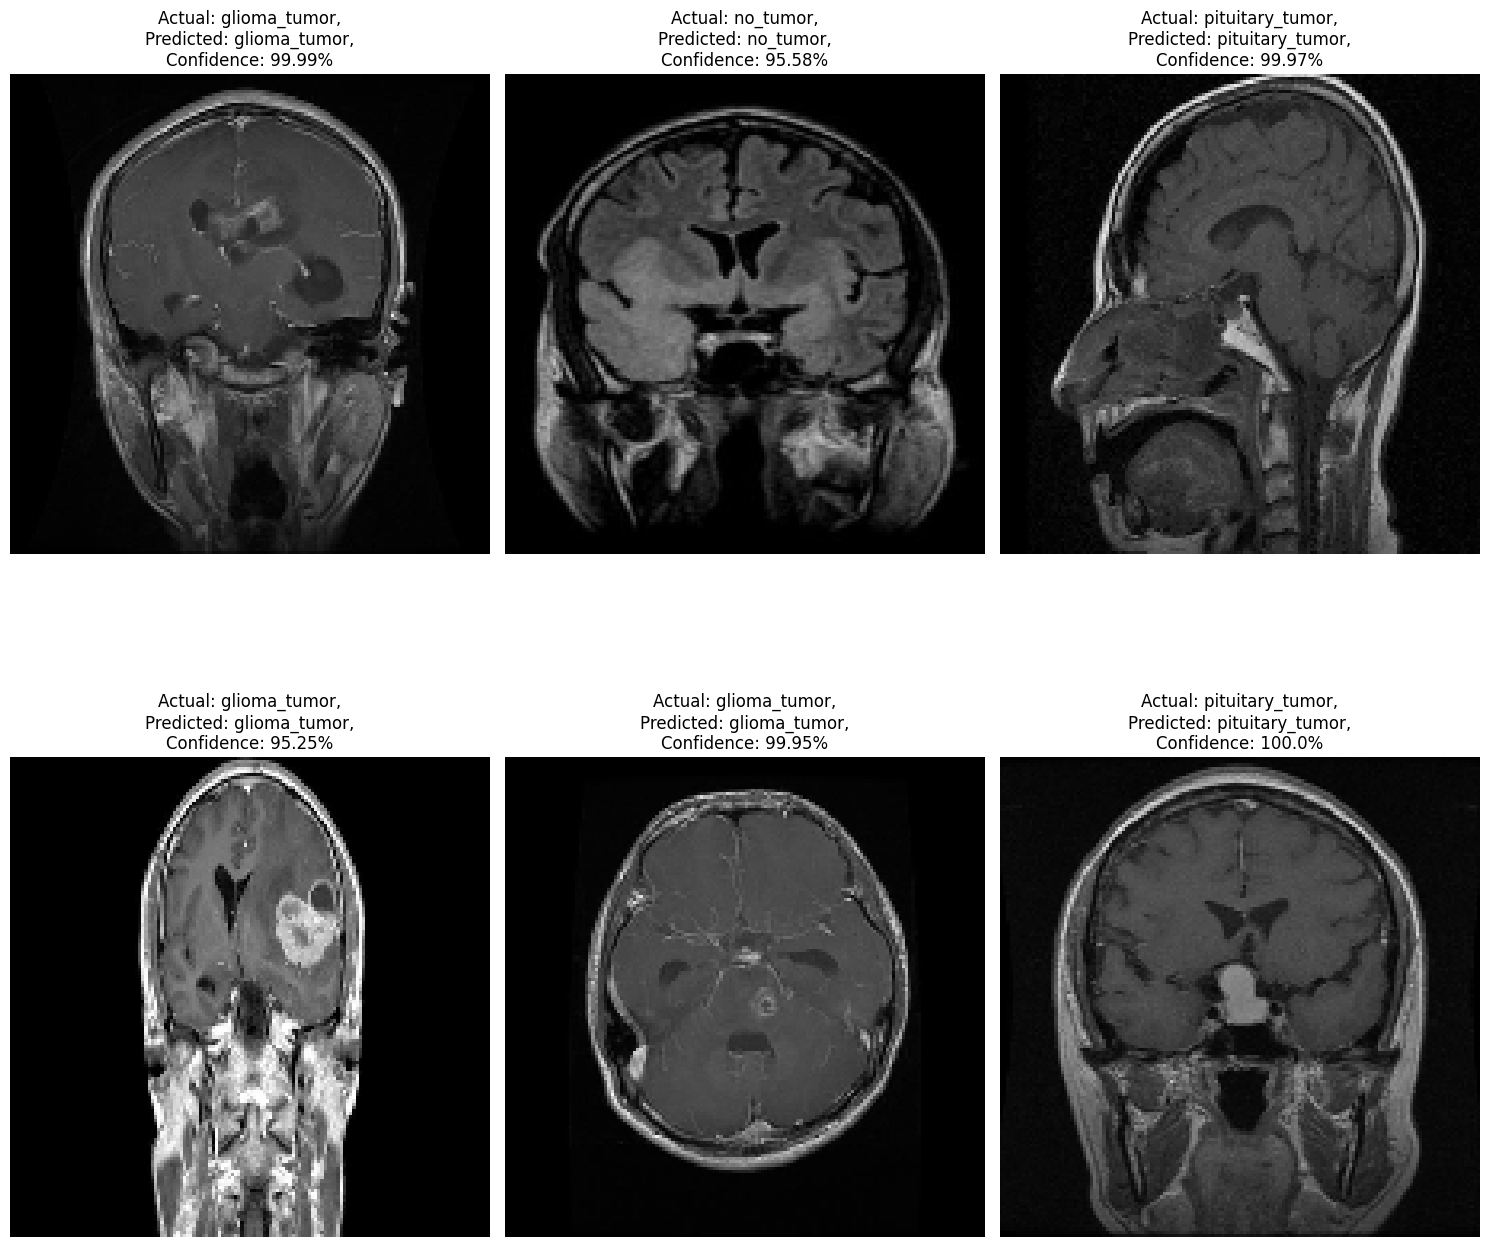

In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)  
    img_array = tf.expand_dims(img_array, 0) 


    predictions = model.predict(img_array)  

    predicted_class_idx = np.argmax(predictions[0])  
    predicted_class = labels[predicted_class_idx]  
    confidence = round(100 * (np.max(predictions[0])), 2)  

    return predicted_class, confidence


class_names = labels  

num_samples = 6


plt.figure(figsize=(15, 15))


random_indices = np.random.choice(len(X_test), num_samples, replace=False)


for i, index in enumerate(random_indices):
    ax = plt.subplot(2, 3, i + 1)  
    img = X_test[index]  
    plt.imshow(img.astype("uint8"))  
    
    
    predicted_class, confidence = predict(model, img)
    actual_class = class_names[np.argmax(y_test[index])]  
    
  
    plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class},\nConfidence: {confidence}%")
    
    plt.axis("off")  

    
plt.tight_layout()
plt.show()


# Plotting the Classification Report for Test Dataset

In [26]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95        93
           1       0.96      0.96      0.96        51
           2       0.99      0.94      0.96        96
           3       0.96      1.00      0.98        87

    accuracy                           0.96       327
   macro avg       0.96      0.96      0.96       327
weighted avg       0.96      0.96      0.96       327



# Plotting the Confusion Matrix for Test Dataset

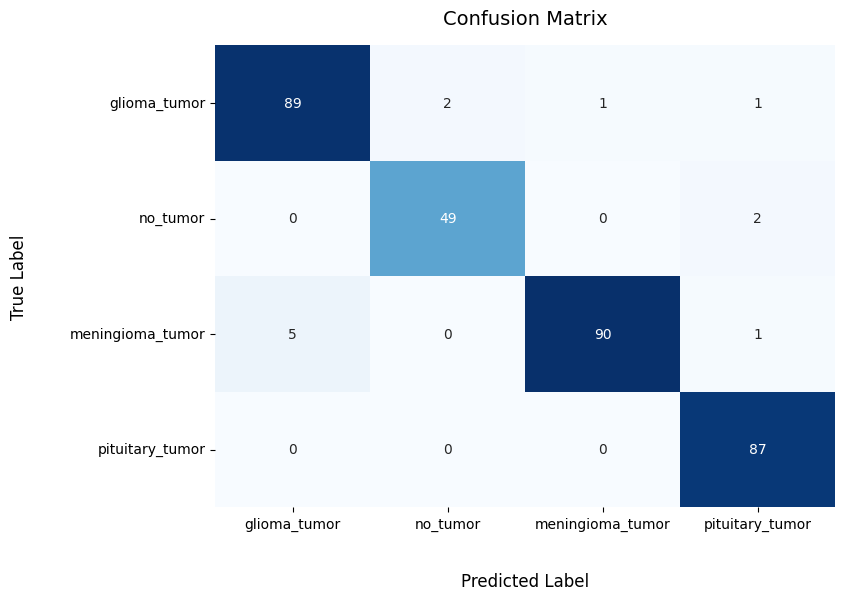

In [27]:

cm = confusion_matrix(y_test_new, pred)


plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)


heatmap.set_xlabel('Predicted Label', fontsize=12, labelpad=30)  
heatmap.set_ylabel('True Label', fontsize=12, labelpad=30)  

plt.title('Confusion Matrix', fontsize=14, pad=15) 
plt.show()

Save the model for deployment

In [28]:
!rm -rf /kaggle/working/*

In [29]:
import os


save_path = '/kaggle/working/my_saved_model.keras'

# Save the model in the native Keras format with the .keras extension
model.save(save_path)


import zipfile

from IPython.display import FileLink, display


folder_to_zip = '/kaggle/working/my_saved_model'  


zip_file_path = '/kaggle/working/my_saved_model.zip'


with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zf:
    
    for dirname, _, files in os.walk(folder_to_zip):
        for file in files:
            file_path = os.path.join(dirname, file)
            zf.write(file_path, os.path.relpath(file_path, folder_to_zip))


download_link = FileLink(zip_file_path, result_html_prefix="Click to download: ")

display(download_link)

/kaggle/working/my_saved_model.zip